# Compute Segmentations on PathFinder-SEGMENTATION Dataset
This notebook is for inspecting the PathFinder-SEGMENTATION dataset and formatting it into a Meerkat dataset.

> **Simplifying and Understanding State Space Models with Diagonal Linear RNNs**\
> Ankit Gupta, Harsh Mehta, Jonathan Berant\
> Paper: https://arxiv.org/abs/2212.00768


In [1]:
import pickle as pik
import numpy as np
import torch
import matplotlib.pyplot as plt
import PIL
import pickle as pik

import os
import pandas as pd

import meerkat as mk
from meerkat.interactive.formatter.image import ImageFormatterGroup

%load_ext autoreload
%autoreload 2

In [2]:
# The path to the pathfinder-segmentation dataset.
# pathfinder_path = "/Users/arjundd/code/dlr/src/dataloaders/prepare/pathfinder/data/pathfinder256_segmentation"
pathfinder_path = "/home/data/pathfinder-segmentation/pathfinder256_segmentation"


In [3]:
def extract_metadata(dirpath, base_path: str):
    """Extract the filepath and label from the metadata file.

    Example metadata:
        ['imgs/43', 'sample_0.png', '0', '0', '1.8', '6', '2.0', '5', '1.5', '2', '1']
    
    Args:
        file_path: Path to the metadata file.
    """
    metadata_dir = os.path.join(dirpath, "metadata")
    image_paths = []
    labels = []
    for metadata_file in os.listdir(metadata_dir):
        file_path = os.path.join(metadata_dir, metadata_file)
        meta_examples = np.load(file_path)
        for m_example in meta_examples:
            image_paths.append(os.path.join(base_path, m_example[0], m_example[1]))
            labels.append(int(m_example[3]))
    return {"path": image_paths, "label": labels}


def get_segmentation_path(image_path):
    """Get the segmentation path from the image path."""
    return image_path.replace("imgs", "paths").replace(".png", ".pkl")


def load_segmentation(seg_path):
    """Load the segmentation from a file."""
    with open(seg_path, "rb") as f:
        data = pik.load(f)
    d = data
    [origin_mark_idx, terminal_mark_idx] = d['marker_indices']

    paths = []
    for i, path_inds in enumerate(d['segs']):
        path = np.zeros(d['image_size'], dtype=np.int16)
        path[path_inds] = 1 + (origin_mark_idx == terminal_mark_idx == i)
        paths.append(path)
    return torch.LongTensor(np.maximum(*paths))

_COLORS = [
    (0, 0, 0),
    (255, 0, 0),
    (0, 0, 255),
]
_COLORS = [np.asarray(c) for c in _COLORS]


def colorize(x: torch.Tensor) -> PIL.Image:
    """Colorize the segmentation array.

    Args:
        x: An array representing the segmentation (..., num_classes)

    Returns:
        An array of shape (..., 4) where the last dimension is RGBA.
    """
    arr = x.numpy()
    arr = np.zeros(x.shape + (3,), dtype=np.uint8)
    num_classes = 3
    for k in range(num_classes):
        arr[x == k] = _COLORS[k]
    return PIL.Image.fromarray(arr, "RGB")


In [4]:
# Format the metadata for each subfolder.
df = pd.DataFrame(extract_metadata(pathfinder_path, base_path=os.path.join(pathfinder_path, "")))
df["seg_path"] = df["path"].apply(get_segmentation_path)

df_pd = df.reset_index(drop=True)

df = mk.DataFrame.from_pandas(df_pd)
df["image"] = mk.files(df["path"], type="image")
df["seg"] = mk.files(df["seg_path"], loader=load_segmentation)
df["seg_colorized"] = df["seg"].defer(colorize)
df["seg_colorized"].formatters = ImageFormatterGroup().defer()

df = df.drop(columns="index")

,path,label,seg_path,image,seg,seg_colorized
0,/home/data/pathfinder-segmentation/pathfinder256_segmentation/imgs/5/sample_0.png,1,/home/data/pathfinder-segmentation/pathfinder256_segmentation/paths/5/sample_0.pkl,,"tensor([[0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], ..., [0, 0, 0,...",
1,/home/data/pathfinder-segmentation/pathfinder256_segmentation/imgs/5/sample_1.png,1,/home/data/pathfinder-segmentation/pathfinder256_segmentation/paths/5/sample_1.pkl,,"tensor([[0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], ..., [0, 0, 0,...",
2,/home/data/pathfinder-segmentation/pathfinder256_segmentation/imgs/5/sample_2.png,1,/home/data/pathfinder-segmentation/pathfinder256_segmentation/paths/5/sample_2.pkl,,"tensor([[0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], ..., [0, 0, 0,...",
3,/home/data/pathfinder-segmentation/pathfinder256_segmentation/imgs/5/sample_3.png,1,/home/data/pathfinder-segmentation/pathfinder256_segmentation/paths/5/sample_3.pkl,,"tensor([[0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], ..., [0, 0, 0,...",
4,/home/data/pathfinder-segmentation/pathfinder256_segmentation/imgs/5/sample_4.png,1,/home/data/pathfinder-segmentation/pathfinder256_segmentation/paths/5/sample_4.pkl,,"tensor([[0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], ..., [0, 0, 0,...",

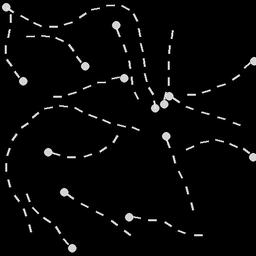
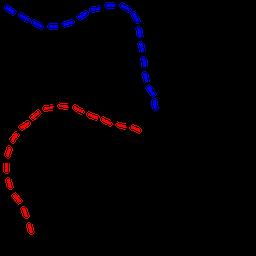
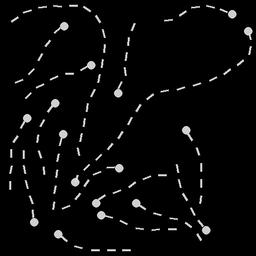
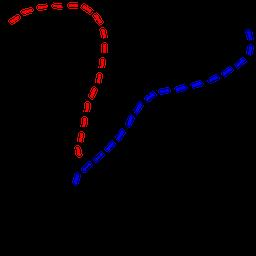
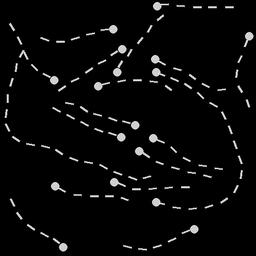
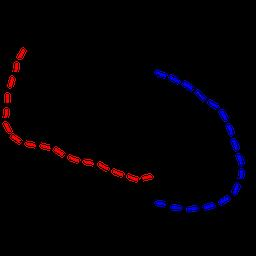
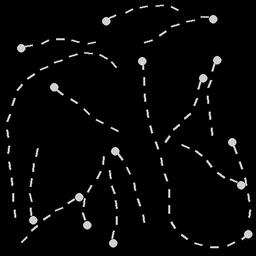
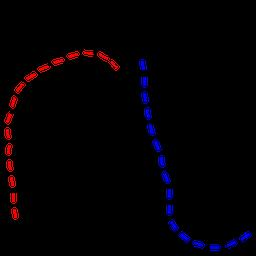
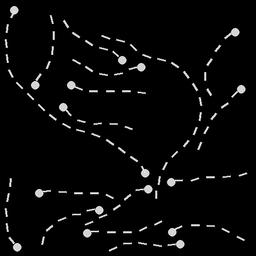
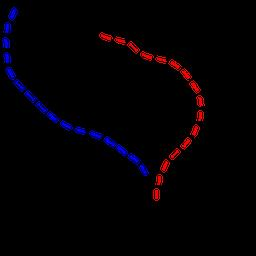

In [5]:
df.head()

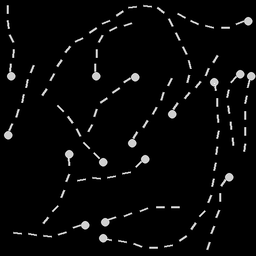

In [6]:
# img = PIL.Image.open("/Users/arjundd/code/dlr/src/dataloaders/prepare/pathfinder/data/imgs/0/sample_2.png")
img = PIL.Image.open("/home/data/pathfinder-segmentation/pathfinder256_segmentation/imgs/0/sample_2.png")
img

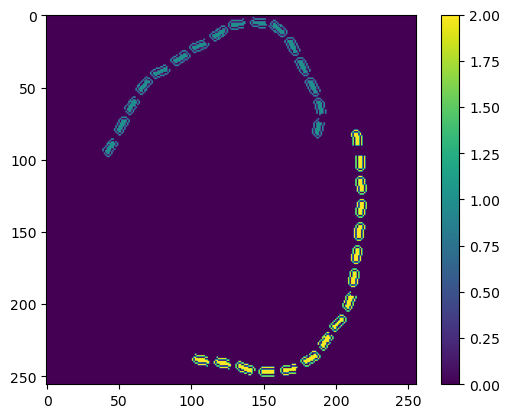

In [7]:
# pickle_path = "/Users/arjundd/code/dlr/src/dataloaders/prepare/pathfinder/data/paths/0/sample_2.pkl"
pickle_path = "/home/data/pathfinder-segmentation/pathfinder256_segmentation/paths/0/sample_2.pkl"

with open(pickle_path, "rb") as f:
    data = pik.load(f)

d = data
[origin_mark_idx, terminal_mark_idx] = d['marker_indices']

paths = []
for i, path_inds in enumerate(d['segs']):
    path = np.zeros(d['image_size'], dtype=np.int16)
    path[path_inds] = 1 + (origin_mark_idx == terminal_mark_idx == i)
    paths.append(path)
label_mask = torch.LongTensor(np.maximum(*paths))        

plt.imshow(label_mask)
plt.colorbar()

In [8]:
import numpy as np
# np_path = "/Users/arjundd/code/dlr/src/dataloaders/prepare/pathfinder/data/metadata/0.npy"
np_path = "/home/data/pathfinder-segmentation/pathfinder256_segmentation/metadata/0.npy"
data = np.load(np_path)
data[2]

array(['imgs/0', 'sample_2.png', '2', '1', '2.2', '16', '5', '8', '2',
       '4', '1'], dtype='<U32')

In [9]:
import os
import io
from pathlib import Path
import itertools
from collections import Counter
import pickle

import pdb

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from PIL import Image  # Only used for Pathfinder
from einops.layers.torch import Rearrange, Reduce
from einops import rearrange

In [46]:

# All code was adapted from:
# https://github.com/ag1988/dlr/blob/main/src/dataloaders/datasets.py

class SequenceDataset:
    registry = {}
    _name_ = NotImplementedError("Dataset must have shorthand name")

    # Since subclasses do not specify __init__ which is instead handled by this class
    # Subclasses can provide a list of default arguments which are automatically registered as attributes
    # TODO apparently there is a python 3.8 decorator that basically does this
    @property
    def init_defaults(self):
        return {}

    # https://www.python.org/dev/peps/pep-0487/#subclass-registration
    def __init_subclass__(cls, **kwargs):
        super().__init_subclass__(**kwargs)
        cls.registry[cls._name_] = cls

    def __init__(self, _name_, data_dir=None, mode="seg", io_dim="1d", **dataset_cfg):
        assert _name_ == self._name_
        self.data_dir = Path(data_dir).absolute() if data_dir is not None else None
        self.mode = mode
        self.io_dim = io_dim

        # Add all arguments to self
        init_args = self.init_defaults
        init_args.update(
            dataset_cfg
        )  # TODO this overrides the default dict which is bad
        for k, v in init_args.items():
            setattr(self, k, v)

        self.init()  # Extra init stuff if desired # TODO get rid of this

        # train, val, test datasets must be set by class instantiation
        self.dataset_train = None
        self.dataset_val = None
        self.dataset_test = None
        
        self.shuffle_train = True

    def init(self):
        pass

    def setup(self):
        """This method should set self.dataset_train, self.dataset_val, and self.dataset_test"""
        raise NotImplementedError

    def split_train_val(self, val_split):
        train_len = int(len(self.dataset_train) * (1.0 - val_split))
        self.dataset_train, self.dataset_val = torch.utils.data.random_split(
            self.dataset_train,
            (train_len, len(self.dataset_train) - train_len),
            generator=torch.Generator().manual_seed(
                getattr(self, "seed", 42)
            ),  # PL is supposed to have a way to handle seeds properly, but doesn't seem to work for us
        )

    @staticmethod
    def collate_fn(batch, resolution=1):
        """batch: list of (x, y) pairs"""
        def _collate(batch, resolution=1):
            # From https://github.com/pytorch/pytorch/blob/master/torch/utils/data/_utils/collate.py
            elem = batch[0]
            if isinstance(elem, torch.Tensor):
                out = None
                if torch.utils.data.get_worker_info() is not None:
                    # If we're in a background process, concatenate directly into a
                    # shared memory tensor to avoid an extra copy
                    numel = sum(x.numel() for x in batch)
                    storage = elem.storage()._new_shared(numel)
                    out = elem.new(storage)
                x = torch.stack(batch, dim=0, out=out)
                if resolution is not None:
                    x = x[:, ::resolution] # assume length is first axis after batch
                return x
            else:
                return torch.tensor(batch)

        x, y = zip(*batch)
        # Drop every nth sample
        # x = torch.stack(x, dim=0)[:, ::resolution]
        # y = torch.LongTensor(y)
        # y = torch.tensor(y)
        # y = torch.stack(y, dim=0)
        x = _collate(x, resolution=resolution)
        y = _collate(y, resolution=None)
        return x, y

    def train_dataloader(self, train_resolution, eval_resolutions, **kwargs):
        if train_resolution is None:
            train_resolution = [1]
        if not is_list(train_resolution):
            train_resolution = [train_resolution]
        assert len(train_resolution) == 1, "Only one train resolution supported for now"
        
        if "shuffle" not in kwargs and self.shuffle_train is not None:
            kwargs["shuffle"] = self.shuffle_train
        return self._dataloader(
            self.dataset_train,
            resolutions=train_resolution,
            # shuffle=True,
            **kwargs,
        )[0]

    def val_dataloader(self, **kwargs):
        return self._eval_dataloader(self.dataset_val, **kwargs)

    def test_dataloader(self, **kwargs):
        return self._eval_dataloader(self.dataset_test, **kwargs)

    def _eval_dataloader(self, dataset, train_resolution, eval_resolutions, **kwargs):
        if eval_resolutions is None:
            eval_resolutions = [1]
        if not is_list(eval_resolutions):
            eval_resolutions = [eval_resolutions]

        kwargs["shuffle"] = False if "shuffle" not in kwargs else kwargs["shuffle"]
        dataloaders = self._dataloader(
            dataset,
            resolutions=eval_resolutions,
            # shuffle=False, 
            **kwargs,
        )

        return (
            {
                str(res) if res > 1 else None: dl
                for res, dl in zip(eval_resolutions, dataloaders)
            }
            if dataloaders is not None
            else None
        )

    def _dataloader(self, dataset, resolutions, **loader_args):
        if dataset is None:
            return None

        return [
            torch.utils.data.DataLoader(
                dataset,
                collate_fn=partial(self.collate_fn, resolution=resolution)
                if self.collate_fn is not None
                else None,
                **loader_args,
            )
            for resolution in resolutions
        ]

    def __str__(self):
        return self._name_


class PathFinderSegmentationDataset(torch.utils.data.Dataset):
    """Path Finder dataset with extra supervision."""

    def __init__(self, data_dir, mode, io_dim, input_transform, prepare_target):
        """
        Args:
            data_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            prepare_target: function for preparing target from path supervision file
        """
        self.data_dir = Path(data_dir).expanduser()
        assert self.data_dir.is_dir(), f"data_dir {str(self.data_dir)} does not exist"
        self.input_transform = input_transform
        self.prepare_target = prepare_target
        samples = []
        path_list = sorted(
            list((self.data_dir / "metadata").glob("*.npy")),
            key=lambda path: int(path.stem),
        )
        assert path_list, "No metadata found"
        for metadata_file in path_list:
            for metadata in np.load(metadata_file).tolist():
                image_path = Path(metadata[0]) / metadata[1]   # 'imgs/0', 'sample_0.png'
                label = int(metadata[3])  
                segments_path = Path(metadata[0].replace('imgs/', 'paths/')) / metadata[1].replace('.png', '.pkl')
                # 'paths/0', 'sample_0.pkl'
                samples.append((image_path, label, segments_path))
        self.samples = samples
        self.mode = mode 
        # "seg" for segmentation
        # "sod" for weakly supervised salient object detection
        self.io_dim = io_dim
    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, label, segments_path = self.samples[idx]
        # https://github.com/pytorch/vision/blob/9b29f3f22783112406d9c1a6db47165a297c3942/torchvision/datasets/folder.py#L247
        with open(self.data_dir / image_path, "rb") as f:
            orig_sample = Image.open(f).convert("L")  # Open in grayscale
        
        if self.input_transform is not None:
            sample = self.input_transform(orig_sample)
        
        segmentation = pickle.load(open(self.data_dir / segments_path,'rb'))
        target = self.prepare_target(segmentation, label, orig_sample, self.io_dim)
        
        if self.mode == "sod": # weakly supervised salient object detection
            target = torch.max(target) - 1 
            # if path exists: (max=2) - 1 = 1
            # else: (max=1) - 1 = 0

        return sample, target


class PathFinderSegmentation(SequenceDataset):
    _name_ = "pathfinder_segmentation"
    d_output = 3
    l_output = None
    
    @property
    def d_input(self):
        if self.pos_info:
            return 4+2 if self.all_corners else 1+2
        return 4 if self.all_corners else 1

    @property
    def n_tokens(self):
        if self.tokenize:
            return 256

    @property
    def init_defaults(self):
        return {
            "resolution": 128,
            "sequential": True,
            "tokenize": False,
            "autoregressive": False,  # if sequential, pad by L 0's on right and take last L outputs
            "pool": 1,
            "all_corners": False,     # stack 0,90,180,270 degree rotations
            "val_split": 0.1,
            "test_split": 0.1,
            "seed": 42,  # Controls the train/val/test split
            "pos_info": False,
        }

    def init(self):
        if self.data_dir is None:
            self.data_dir = (
                self.data_path / self._name_ / f"pathfinder{self.resolution}_segmentation"
            )
        if self.autoregressive: 
            assert self.sequential
            self.l_output = self.resolution**2
            
    def rotations(self, x, dim=-3):
        assert x.shape[-2] == x.shape[-1], 'must be square'
        assert x.ndim >= 3
        rotations = [x] + [torchvision.transforms.functional.rotate(x, 90*i) for i in range(1,4)]
        return torch.cat(rotations, dim=dim)
    
    def concat_pos(self, x):
        """ append in last dim the position info of second-last dim 
        """
        L = x.shape[-2]                         # (... L d)
        pos = (2*np.pi*torch.arange(L, device=x.device) / L).view(-1,1)
        cos = torch.zeros_like(x[...,:1]) + pos.cos()
        sin = torch.zeros_like(x[...,:1]) + pos.sin()
        return torch.cat((x,cos,sin), dim=-1)   # (... L d+2)
    
    def zero_pad_right(self, x, dim=-2):
        assert dim < 0
        L = x.shape[dim]
        assert self.l_output == L
        return F.pad(x, (0,0)*abs(dim+1) + (0,L))
    
    def input_transform(self):
        transform_list = [torchvision.transforms.ToTensor()]
        if self.io_dim == "2d":
            if self.tokenize:
                transform_list.append(torchvision.transforms.Lambda(lambda x: (x * 255).long()))
            else:
                transform_list.append(torchvision.transforms.Normalize(mean=0.5, std=0.5))
            return torchvision.transforms.Compose(transform_list)
        # else: do the following:

        if self.pool > 1:
            transform_list.append(
                Reduce(
                    "1 (h h2) (w w2) -> 1 h w",
                    "mean",
                    h2=self.pool,
                    w2=self.pool,
                )
            )
        if self.tokenize:
            transform_list.append(
                torchvision.transforms.Lambda(lambda x: (x * 255).long())
            )
        else:
            transform_list.append(torchvision.transforms.Normalize(mean=0.5, std=0.5))
        if self.all_corners:
            transform_list.append(self.rotations)    # (4 h w)
        if self.sequential:
            # If tokenize, it makes more sense to get rid of the channel dimension
            transform_list.append(
                Rearrange("1 h w -> (h w)")
                if self.tokenize and not self.all_corners
                else Rearrange("r h w -> (h w) r")
            )
            if not self.tokenize and self.pos_info:
                transform_list.append(self.concat_pos)
            if self.autoregressive:
                transform_list.append(
                    partial(self.zero_pad_right, dim=-1) 
                    if self.tokenize
                    else partial(self.zero_pad_right, dim=-2)
                )
        return torchvision.transforms.Compose(transform_list)
    
    def prepare_target(self, d, label=None, orig_sample=None, io_dim=None):
        # d.keys(): 'segs', 'origin_tips', 'terminal_tips', 'marker_indices', 'image_size'
        [origin_mark_idx, terminal_mark_idx] = d['marker_indices']
        
        if label is not None:
            assert label == (origin_mark_idx == terminal_mark_idx)
        
        paths = []
        for i, path_inds in enumerate(d['segs']):
            path = np.zeros(d['image_size'], dtype=np.int16)
            path[path_inds] = 1 + (origin_mark_idx == terminal_mark_idx == i)
            paths.append(path)
        # 0: not on a long path, 1: on a long path but not any connecting path, 2: on a connecting path 
        label_mask = torch.LongTensor(np.maximum(*paths))        
        
        # sanity
        # label_mask = (torchvision.transforms.ToTensor()(orig_sample) > 0).long().squeeze(0)
        if io_dim == "1d":
            if self.sequential:
                label_mask = rearrange(label_mask, "h w -> (h w)")
                
        return label_mask
        
    def prepare_data(self):
        if not self.data_dir.is_dir():
            raise FileNotFoundError(
            f"""
            Directory {str(self.data_dir)} not found.
            To get the dataset, generate pathfinder data using /src/dataloaders/prepare/pathfinder .
            Then point data_dir to the pathfinderX_segmentation directory, where X is either 128, or 256.
            """
            )

    def setup(self, stage=None):
        if stage == "test" and hasattr(self, "dataset_test"):
            return
        
        # [2021-08-18] TD: I ran into RuntimeError: Too many open files.
        # https://github.com/pytorch/pytorch/issues/11201
        torch.multiprocessing.set_sharing_strategy("file_system")
        dataset = PathFinderSegmentationDataset(self.data_dir, self.mode, self.io_dim, self.input_transform(), self.prepare_target)
        len_dataset = len(dataset)
        print(f'Total num of samples = {len_dataset}')
        val_len = int(self.val_split * len_dataset)
        test_len = int(self.test_split * len_dataset)
        train_len = len_dataset - val_len - test_len
        (
            self.dataset_train,
            self.dataset_val,
            self.dataset_test,
        ) = torch.utils.data.random_split(
            dataset,
            [train_len, val_len, test_len],
            generator=torch.Generator().manual_seed(self.seed),
        )

In [51]:
pathfinder_path = "/home/data/pathfinder-segmentation/pathfinder256_segmentation"
mode = "sod"
io_dim = "2d"
pfs = PathFinderSegmentation("pathfinder_segmentation", data_dir=pathfinder_path, mode=mode, io_dim=io_dim)

In [52]:
pfs.setup()

Total num of samples = 100000


In [53]:
pfs.dataset_train

In [54]:
for el in pfs.dataset_train:
    print(el[0])
    print(el[1])
    print(el[0].shape)
    print(el[1].shape)
    break

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])
tensor(0)
torch.Size([1, 256, 256])
torch.Size([])


In [102]:
if mode == "sod":
    print(el[1])
else:
    plt.scatter(range(len(el[1])), el[1])

tensor(0)
